In [1]:
import bisect
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

## Preparación del dataset

### Adaptar el dataset

In [2]:
df = pd.read_csv('../data/data_engineered.csv')

In [3]:
# df = df.drop(columns=['first', 'last', 'city_pop', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'hour_window', 'unix_time'])
df = df.drop(columns=['first', 'last', 'city_pop', 'street', 'job', 'dob', 'trans_num', 'hour_window', 'unix_time'])

In [4]:
# df['hour_window_unix'] = df['hour_window'].astype('int64') // 10**9
# df['unix_time'] = df['unix_time'].astype('int64') // 10**9

### Separación de la data 

In [5]:
train_mask = (df['trans_month'] == 12) & (df['year'] == 2020)
df_train = df[~train_mask]

df_test = df[((df['trans_month'] == 12) & (df['year'] == 2020))]

In [6]:
X_train = df_train.drop(columns=['is_fraud'])
y_train = df_train['is_fraud']

X_test = df_test.drop(columns=['is_fraud'])
y_test = df_test['is_fraud']

In [7]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

In [8]:
categorical_cols

Index(['merchant', 'category', 'gender', 'city', 'state'], dtype='object')

In [9]:
numerical_cols

Index(['cc_num', 'amt', 'zip', 'lat', 'long', 'merch_lat', 'merch_long',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'dist_between_client_and_merch',
       'trans_month', 'trans_day', 'hour', 'year', 'times_shopped_at_merchant',
       'times_shopped_at_merchant_year', 'times_shopped_at_merchant_month',
       'times_shopped_at_merchant_day', 'time_diff_seconds', 'trans_per_hour',
       'hour_trans_ratio', 'unusual_distance', 'distance_diff',
       'velocity_km_h', 'mean_dist_merchant', 'std_dist_merchant',
       'dist_z_score', 'amt_month_ratio', 'amt_year_ratio',
       'mean_amt_category', 'std_amt_category', 'amt_z_score',
       'high_amt_first_time', 'mean_times_day_merchant',
       'std_times_day_merchant', 'times_day_z_score', 'fraud_rate_merchant',
       'unique_cards_per_hour', 'amt_variance_hour'],
      dtype='object')

In [10]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

In [11]:
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on training data and transform both train and test
    X_train_processed[col] = le.fit_transform(X_train[col].astype(str)) # Ensure string type

    # Handle new/unseen categories in test data
    # Map them to a placeholder that will be included in the encoder's classes
    X_test_processed[col] = X_test[col].astype(str).map(lambda s: '<unknown>' if s not in le.classes_ else s)
    
    if '<unknown>' not in le.classes_:
        # Add '<unknown>' to the LabelEncoder's classes if it's not already there
        # and it appeared in the test set after mapping
        if X_test_processed[col].eq('<unknown>').any():
            le_classes = le.classes_.tolist()
            bisect.insort_left(le_classes, '<unknown>') # Keep sorted for consistency
            le.classes_ = np.array(le_classes)
        
    X_test_processed[col] = le.transform(X_test_processed[col])

## Primer Intento

Definimos los parámetros para nuestro modelo

In [12]:
lgbm_classifier = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    objective='binary',
    random_state=123,
    n_jobs=2,
    is_unbalance=True
)

Entrenamos el modelo que definimos con la data de entrenamiento

In [13]:
lgbm_classifier.fit(X_train_processed, y_train)

[LightGBM] [Info] Number of positive: 9393, number of negative: 1703463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7386
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005484 -> initscore=-5.200454
[LightGBM] [Info] Start training from score -5.200454


LGBMClassifier(is_unbalance=True, n_jobs=2, objective='binary',
               random_state=123)

Obtenemos las predicciones del modelo entrenado utilizando los datos de prueba

In [14]:
y_pred_lgbm = lgbm_classifier.predict(X_test_processed)
y_pred_proba_lgbm = lgbm_classifier.predict_proba(X_test_processed)[:, 1]

Comparamos los resultados de las predicciones

LightGBM Model Evaluation:


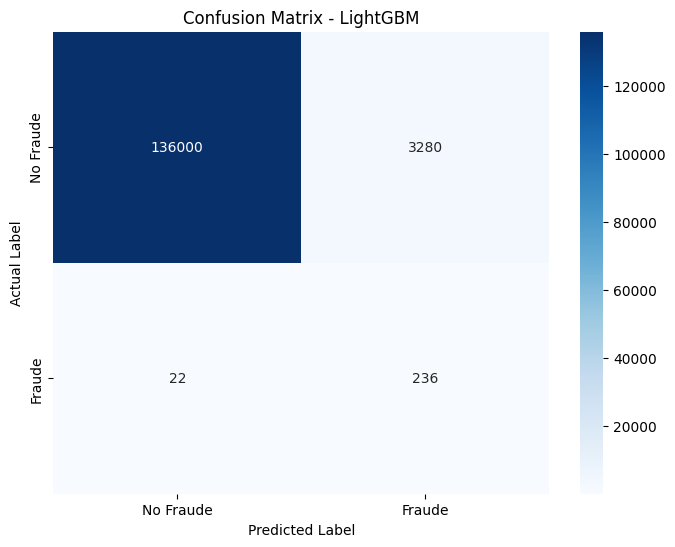

In [15]:
print("LightGBM Model Evaluation:")
cm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


En la gráfica se puede ver que nuestro modelo es muy bueno sabiendo cuando una transacción es no fraude, sin embargo, se puede ver que también tiende a confundir algunas transacciones como fraude cuando no lo son. cuando vemos la clasificación de las transacciones fraudulentas, podemos ver que nuestras si lográ identificar un 93% de las transacciones fraudulentas, lo cual es menos del 7% para errores de tipo 2. En cambio, cuando miramos los errores de tipo 1, se puede ver que nuestro modelo no parece reconocer muy bien los fraudes, ya que nos devuelve muchas transacciones legítimas como fraudulentas.

In [16]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Not Fraud', 'Fraud']))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lgbm))

print("\nF1 Score:")
print(f1_score(y_test, y_pred_lgbm, average='weighted'))



Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    139280
       Fraud       0.07      0.91      0.13       258

    accuracy                           0.98    139538
   macro avg       0.53      0.95      0.56    139538
weighted avg       1.00      0.98      0.99    139538


ROC AUC Score:
0.9681337075724992

F1 Score:
0.9864103591856883


In [17]:
print("\nFeature Importances (LightGBM):")
importances = lgbm_classifier.feature_importances_
feature_names = X_train_processed.columns
sorted_indices = np.argsort(importances)[::-1]

for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


Feature Importances (LightGBM):
amt_z_score: 240
amt: 220
hour_trans_ratio: 184
amt_month_shopping_net_spend: 177
amt_month_ratio: 156
fraud_rate_merchant: 147
hour: 144
mean_times_day_merchant: 132
time_diff_seconds: 119
amt_month: 113
amt_year: 101
times_day_z_score: 88
amt_year_ratio: 87
cc_num: 81
category: 77
std_times_day_merchant: 77
city: 67
mean_dist_merchant: 46
count_month_shopping_net: 46
velocity_km_h: 45
amt_variance_hour: 43
distance_diff: 43
std_dist_merchant: 43
merchant: 40
zip: 39
lat: 38
trans_per_hour: 36
merch_lat: 34
times_shopped_at_merchant: 33
mean_amt_category: 33
times_shopped_at_merchant_year: 31
dist_between_client_and_merch: 31
merch_long: 29
state: 27
long: 25
trans_day: 24
dist_z_score: 23
trans_month: 23
gender: 14
std_amt_category: 13
high_amt_first_time: 10
first_time_at_merchant: 9
year: 5
times_shopped_at_merchant_month: 4
unique_cards_per_hour: 3
unusual_distance: 0
times_shopped_at_merchant_day: 0


Imprimimos las features más importantes dentro de las predicciones del modelo

## Métricas Personalizadas

In [18]:
# Crear datasets de LightGBM
train_data = lgb.Dataset(X_train_processed, label=y_train)
test_data = lgb.Dataset(X_test_processed, label=y_test, reference=train_data)

### Métrica para error en general

In [19]:
# Configurar parámetros
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'is_unbalance': True,
    'boosting_type': 'gbdt',
}

In [20]:
# Función feval personalizada para la tasa de error de clasificación
def custom_error(preds, dataset):
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    # Convertimos las predicciones a clases (umbral 0.5 para clasificación binaria)
    preds_binary = np.where(preds > 0.5, 1, 0)
    # Calculamos la tasa de error
    error = np.mean(preds_binary != labels)
    # Devolver una tupla: (nombre_métrica, valor_métrica, es_mayor_mejor)
    return 'custom_error', error, False  # Colocamos False porque un error menor es mejor

In [21]:
# Entrenar el modelo con la métrica personalizada
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_error # Colocamos nuestra función de evaluación personalizada
)

[LightGBM] [Info] Number of positive: 9393, number of negative: 1703463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7387
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005484 -> initscore=-5.200454
[LightGBM] [Info] Start training from score -5.200454


In [22]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_improved = model.predict(X_test_processed)
# Convertir a clases
y_pred_binary_improved = np.where(y_pred_improved > 0.5, 1, 0)

# Calcular las métricas
accuracy_improved = accuracy_score(y_test, y_pred_binary_improved)
auc_improved = roc_auc_score(y_test, y_pred_improved)
f1_score_improved = f1_score(y_test, y_pred_binary_improved, average='weighted')

print(f"Accuracy: {accuracy_improved:.4f}")
print(f"AUC: {auc_improved:.4f}")
print(f"F1 Score: {f1_score_improved:.4f}")

Accuracy: 0.9904
AUC: 0.9962
F1 Score: 0.9938


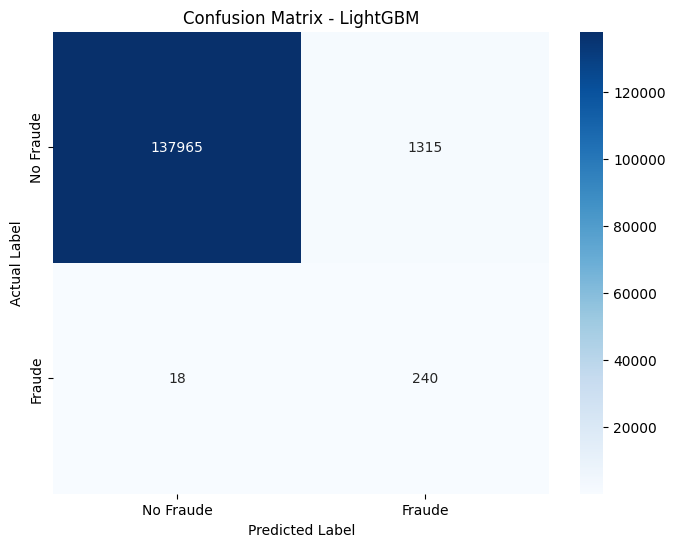

In [23]:
cm = confusion_matrix(y_test, y_pred_binary_improved)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Métrica para disminución de falsos positivos (Error tipo I)

In [24]:
def custom_fp_ratio(preds, dataset):
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    # Calculamos los verdaderos positivos y falsos positivos
    true_positives = np.sum((labels == 1) & (preds_binary == 1))
    false_positives = np.sum((labels == 0) & (preds_binary == 1))
    
    # Calculamos la métrica personalizada: (TP + FP) / TP
    if true_positives == 0:
        ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
    else:
        ratio = (true_positives + false_positives) / true_positives
    
    # Devolver una tupla: (nombre_métrica, valor_métrica, es_mayor_mejor)
    return 'fp_ratio', ratio, False  # False porque una ratio menor es mejor

In [25]:
# Configurar parámetros
params_fp = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.01,
    'num_leaves': 25,
    'is_unbalance': True,
    'boosting_type': 'gbdt',
}

# Entrenar el modelo con la métrica personalizada
model_fp = lgb.train(
    params_fp,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_fp_ratio
)

[LightGBM] [Info] Number of positive: 9393, number of negative: 1703463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7387
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005484 -> initscore=-5.200454
[LightGBM] [Info] Start training from score -5.200454


In [26]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_improved_fp = model_fp.predict(X_test_processed)
# Convertir a clases
y_pred_binary_improved_fp = np.where(y_pred_improved_fp > 0.5, 1, 0)

# Calcular las métricas
accuracy_fp = accuracy_score(y_test, y_pred_binary_improved_fp)
auc_fp = roc_auc_score(y_test, y_pred_improved_fp)
f1_score_fp = f1_score(y_test, y_pred_binary_improved_fp, average='weighted')

print(f"Accuracy: {accuracy_fp:.4f}")
print(f"AUC: {auc_fp:.4f}")
print(f"F1 Score: {f1_score_fp:.4f}")

Accuracy: 0.9896
AUC: 0.9958
F1 Score: 0.9934


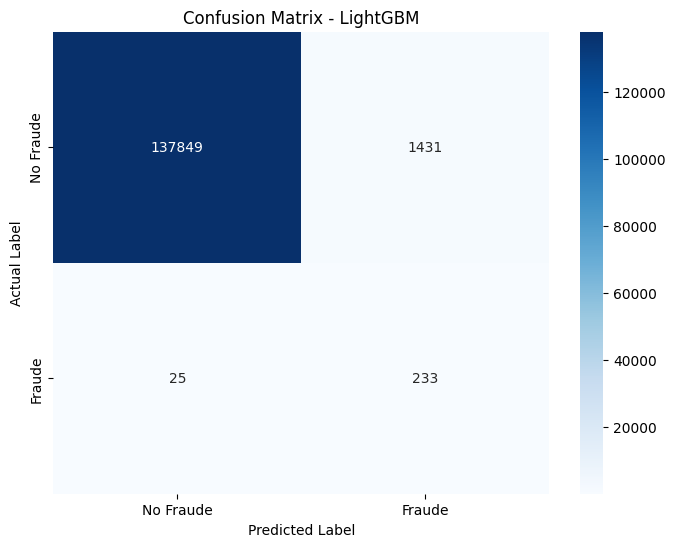

In [27]:
cm = confusion_matrix(y_test, y_pred_binary_improved_fp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Métrica para disminución de falsos negativos (Error de Tipo II)

In [28]:
def custom_fn_ratio(preds, dataset):
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    # Calculamos los verdaderos positivos y falsos negativos
    true_positives = np.sum((labels == 1) & (preds_binary == 1))
    false_negatives = np.sum((labels == 1) & (preds_binary == 0))
    
    # Calculamos la métrica personalizada: FN / (TP + FN)
    if true_positives == 0:
        ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
    else:
        ratio = (true_positives + false_negatives) / true_positives
    
    # Devolver una tupla: (nombre_métrica, valor_métrica, es_mayor_mejor)
    return 'fp_ratio', ratio, False  # False porque una ratio menor es mejor

In [29]:
# Configurar parámetros
params_fn = {
    'objective': 'binary', # Definimos el objetivo de clasificación binaria
    'metric': 'binary_logloss', # Definimos la métrica de evaluación a binar logloss por nuestro objetivo
    'learning_rate': 0.05, # Definimos la tasa de aprendizaje
    'num_leaves': 31, # Definimos el número de hojas de nuestros árboles
    'max_depth': 10, # Definimos la profundidad máxima de nuestros árboles
    'seed': 321, # Definimos la semilla para guardar el estado aleatorio
    'feature_fraction': 0.6, # Definimos la fracción de características a usar en cada iteración (estas son seleccionadas aleatoriamente)
    'lambda_l1': 0.5, # Definimos la regularización L1
    'lambda_l2': 0.7, # Definimos la regularización L2
    'is_unbalance': True, # Le indicamos al modelo que el dataset está desbalanceado
    'boosting_type': 'dart', # Definimos el tipo de boosting a usar (utilizamos DART, ya que es una opción más robusta, aunque más costosa y lenta al momento de entrenar datos)
    'num_threads': 4, # Definimos el número de hilos a usar para realizar el entrenamiento
}

# Entrenar el modelo con la métrica personalizada
model_fn = lgb.train(
    params_fn,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_fn_ratio,
)

[LightGBM] [Info] Number of positive: 9393, number of negative: 1703463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7387
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005484 -> initscore=-5.200454
[LightGBM] [Info] Start training from score -5.200454


In [30]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_improved_fn = model_fn.predict(X_test_processed)
# Convertir a clases
y_pred_binary_improved_fn = np.where(y_pred_improved_fn > 0.5, 1, 0)

# Calcular las métricas
accuracy_fn = accuracy_score(y_test, y_pred_binary_improved_fn)
auc_fn = roc_auc_score(y_test, y_pred_improved_fn)
f1_score_fn = f1_score(y_test, y_pred_binary_improved_fn, average='weighted')

print(f"Accuracy: {accuracy_fn:.4f}")
print(f"AUC: {auc_fn:.4f}")
print(f"F1 Score: {f1_score_fn:.4f}")

Accuracy: 0.9842
AUC: 0.9960
F1 Score: 0.9905


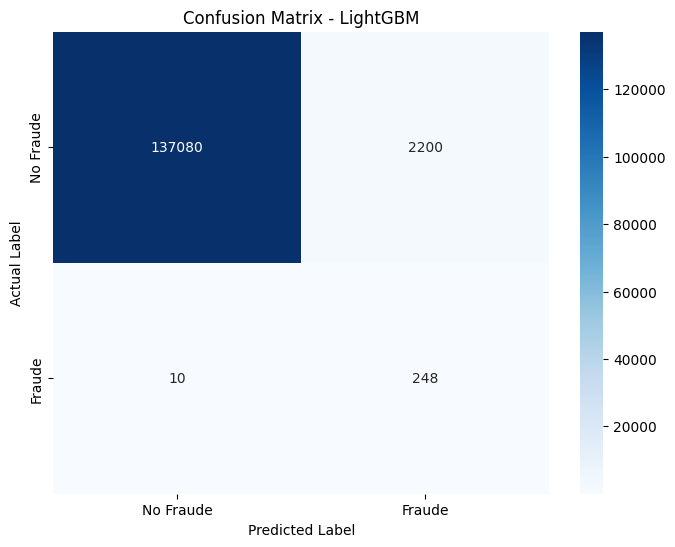

In [31]:
# Desplegamos las predicciones en una matriz de confusión
cm = confusion_matrix(y_test, y_pred_binary_improved_fn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()